# Constrained Optimization

Linear Programming (선형 계획법)의 subset 형태입니다. 다만 Constrained Optimization 가 필요하게 되어 작성하게 되었습니다.

가상의 데이터 x, y가 있다고 하면 우리가 최적화하고자 하는 값은 계수(coefficient) 입니다. 결과적으로 우리가 모르는 값은 계수이며 이 계수 값에 여러값을 대입하여 최적 값을 찾는 형태가 됩니다.

어떤 데이터 x, y 세트가 있다고 생각해봅시다. 이 x, y 세트를 추정하는 어떠한 직선이 있다고 생각했을 때 가장 적절한 선은 다음과 같은 수식을 최소화하는 것이 가장 적절합니다. (최소화 하고자 하는 함수를 보통 목적함수 objective function이라고 합니다.)

$$
\min \sum (y - f(x))^2
$$

당연하게도 위 공식은 최소제곱법, 회귀분석의 기본이며 다양한 방법으로 구할 수 있습니다. `scipy.optimize`에서 제공하는 `minimize`을 사용하여 구하면 다음과 같이 구할 수 있습니다.

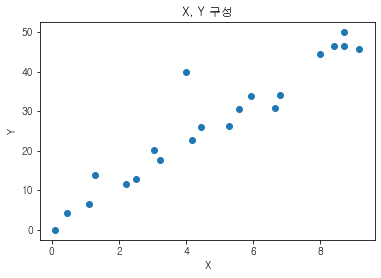

In [10]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.rcParams["font.family"] = "gulim"

df = pl.read_csv("../data/influence2.csv")
x = df["x"].to_numpy()
y = df["y"].to_numpy()

plt.figure()
plt.scatter(x, y)
plt.title("X, Y 구성")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

위 그래프를 확인해보면 추정해야할 식은 1차식이 적절해보입니다. 그러므로 x feature는 다음과 같은 형태를 취해야합니다.

$$
f(x) = w_0 + w_1x
$$

x는 이미 알고 있는 값이며 $w_0$, $w_1$을 추정하는 형태입니다. 목적 함수가 최소화하고자 하는 함수이니 상단에 언급한 공식을 사용하겠습니다.

In [25]:
from functools import partial

## X에 상수항을 포함하기 위해 1을 추가합니다.
x_feature = np.insert(x.reshape(-1, 1), 0, 1, 1)

# Objective funciton을 만듭니다. 다만 x, y는 이미 주어진 값이니 partial로 미리 넣어놓겠습니다.
def objective_function(x, y, w):
    return np.sum((y - x @ w)**2)

objective = partial(objective_function, x_feature, y)

# 초기값을 설정해야하는데, 임의로 1, 1 을 사용하였습니다.
minimize(objective, [1, 1])   

      fun: 421.6321625856126
 hess_inv: array([[ 0.09094438, -0.01413057],
       [-0.01413057,  0.0029742 ]])
      jac: array([0.00000000e+00, 7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([2.95763828, 5.03734456])

$w_0 = 2.96$, $w_1=5.04$라는 값을 얻었습니다. 이를 수식으로 그래프로 그리면 다음과 같습니다. 단, 회귀분석도 동시에 진행해보겠습니다.

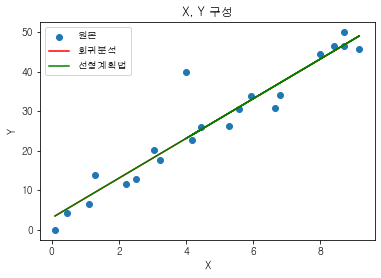

In [36]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression(fit_intercept=False)
regr.fit(x_feature, y)

regr.coef_

plt.figure()
plt.scatter(x, y, label="원본")
plt.plot(x, x_feature @ regr.coef_, c="r", label="회귀분석")
plt.plot(x, x_feature @ np.array([2.96, 5.04]), c="g", label="선형계획법")
plt.title("X, Y 구성")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

회귀분석과 선형계획법의 연산 결과가 같다는 것을 알 수 있습니다. 

선형 모델링은 엔지니어링 관점에서 많이 사용하지만, 어떠한 보정을 한다고 할 때 모델링한 결과값을 100% 적용할 수 있는 것은 아닙니다. 예를 들어 $w_1$의 값이 -4 ~ 4 사이에 있어야한다고 해봅시다. 그렇다면 흔한 선형 회귀로는 이러한 계산이 불가능합니다. 이를 위해 선형계획법을 사용하면 쉽게 해결 할 수 있습니다.

이제 선형계획법에서 Constrained를 적용해보겠습니다. 목적함수에 바로 bounds를 기입하면 됩니다.

In [62]:
## X에 상수항을 포함하기 위해 1을 추가합니다.
x_feature = np.insert(x.reshape(-1, 1), 0, 1, 1)

# Objective funciton을 만듭니다. 다만 x, y는 이미 주어진 값이니 partial로 미리 넣어놓겠습니다.
def objective_function(x, y, w):
    return np.sum((y - x @ w)**2)

objective = partial(objective_function, x_feature, y)

# 제약사항 설정
bound_w0 = [-np.inf, +np.inf]   # w0는 제약사항이 없습니다.
bound_w1 = [-4, +4]

# 초기값을 설정해야하는데, 임의로 1, 1 을 사용하였습니다.
# bounds가 있을 때 사용하는 알고리즘으로 TNC, SLSQP가 있고 여기선 SLSQP를 사용하였습니다. 
minimize(objective, [1, 1], bounds=[bound_w0, bound_w1], method="SLSQP")

     fun: 602.5351129875819
     jac: array([-7.62939453e-06, -3.48780869e+02])
 message: 'Optimization terminated successfully'
    nfev: 17
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([7.88611887, 4.        ])

|    method    |  jac  | hess, hessp | bounds | constraints |
| :----------: | :---: | :---------: | :----: | :---------: |
| Nelder-Mead  |   X   |      X      |   X    |      X      |
|    Powell    |   X   |      X      |        |             |
|      CG      |   O   |      X      |        |             |
|     BFGS     |   O   |      X      |        |             |
|  Newton-CG   |   O   |      O      |        |             |
|   L-BFGS-B   |   O   |      X      |   O    |             |
|     TNC      |   O   |      X      |   O    |             |
|    COBYLA    |   X   |      X      |   X    |      O      |
|    SLSQP     |   O   |      X      |   O    |      O      |
|    dogleg    |   O   |      O      |        |             |
|  trust-ncg   |   O   |      O      |        |             |
| trust-exact  |   O   |      O      |        |             |
| trust-krylov |   O   |      O      |        |             |

참조 : [공학자를 위한 Python] https://wikidocs.net/15656

엄밀하게 이야기하면 bounds는 수식이 아니기 때문에 constrained라고 할 수 없겠으나, 간단하게 제약사항이라고 받아들였으면 합니다. 위에서 구한 $w_0 = 7.89$, $w_1=4$를 토대로 다시 한번 그래프를 보겠습니다.

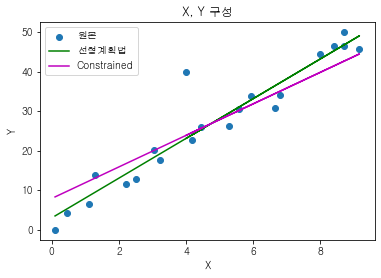

In [64]:
plt.figure()
plt.scatter(x, y, label="원본")
plt.plot(x, x_feature @ np.array([2.96, 5.04]), c="g", label="선형계획법")
plt.plot(x, x_feature @ np.array([7.89, 4.0]), c="m", label="Constrained")
plt.title("X, Y 구성")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()